In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
from numpy import concatenate

Using TensorFlow backend.


In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [3]:
df = read_csv('cm_all.csv', header=0, index_col=1, squeeze=True)
df = df.drop(df.columns[0],axis=1)
df.head()

,cpu_ghz,cpu_usage,cpu_idle,cpu_total,memory_free_mb,memory_usage,memory_total,cpu_usage_tag,period,weekday
ts,,,,,,,,,,
2017-08-04 07:09:00,1.622994,0.058949,7229.349138,7626.006979,73703.339671,0.171460,85762.997397,0,night,6
2017-08-04 07:10:00,1.565744,0.051145,7436.343501,7808.899014,73678.012357,0.171868,85762.997397,-1,night,6
2017-08-04 07:11:00,1.532764,0.050431,7266.985222,7628.050287,73679.538946,0.171852,85762.997397,-1,night,6
2017-08-04 07:12:00,1.537919,0.055125,7251.151273,7645.735222,73662.632567,0.171941,85762.997397,-1,night,6
2017-08-04 07:13:00,1.535036,0.049197,7272.412151,7618.750821,73644.415185,0.172063,85762.997397,-1,night,6


In [4]:
values = df.values

In [5]:
# integer encode direction
# tu: transform all your tag 
encoder = LabelEncoder()
values[:,-1] = encoder.fit_transform(values[:,-1])
values[:,-2] = encoder.fit_transform(values[:,-2])

In [6]:
# ensure all data is float
values = values.astype('float32')

In [7]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [8]:
# specify the number of lag hours
# tu : n_min =set time lag how earlier data will you use to predict current data
n_min = 3
n_features = len(df.columns)

In [9]:
# frame as supervised learning
# series_to_supervised function is used to produce earlier data
reframed = series_to_supervised(scaled, n_min, 1)
print(reframed.shape)

(5496, 40)


In [10]:
#check dataframe processed by series_to_supervised function
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t)
3,0.675438,0.178166,0.746099,0.141518,0.824924,0.226678,0.0,0.2,0.75,0.75,...,0.242970,0.125575,0.771196,0.216026,0.810045,0.243593,0.0,0.0,0.75,0.75
4,0.384414,0.070833,0.984388,0.832260,0.815670,0.241034,0.0,0.0,0.75,0.75,...,0.228314,0.044047,0.795671,0.114113,0.803387,0.247914,0.0,0.0,0.75,0.75
5,0.216763,0.061021,0.789425,0.149235,0.816225,0.240459,0.0,0.0,0.75,0.75,...,0.228037,0.050427,0.792730,0.112547,0.806696,0.244091,0.0,0.0,0.75,0.75
6,0.242970,0.125575,0.771196,0.216026,0.810045,0.243593,0.0,0.0,0.75,0.75,...,0.494092,0.175683,0.710845,0.128136,0.811136,0.238269,0.0,0.2,0.75,0.75
7,0.228314,0.044047,0.795671,0.114113,0.803387,0.247914,0.0,0.0,0.75,0.75,...,0.627787,0.182516,0.687066,0.091911,0.807299,0.240543,0.0,0.2,0.75,0.75


In [11]:
# preserve original data, this dataframe will be used to calculate RMSE 
#between y_prediction and y_realdata in the last two code cells

original_data = reframed[reframed.columns[30:40]]

In [12]:
# set list used to preserve only data what you want to predict
# what to predict is the remove one is this list

unused_col = [("var%d(t)"%i) for i in range(1,11)]
unused_col.remove('var8(t)')

In [13]:
# use drop code to delete other current data except what you want to predict
reframed1 = reframed.drop(unused_col,axis =1)
reframed1.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var8(t)
3,0.675438,0.178166,0.746099,0.141518,0.824924,0.226678,0.0,0.2,0.75,0.75,...,0.061021,0.789425,0.149235,0.816225,0.240459,0.0,0.0,0.75,0.75,0.0
4,0.384414,0.070833,0.984388,0.832260,0.815670,0.241034,0.0,0.0,0.75,0.75,...,0.125575,0.771196,0.216026,0.810045,0.243593,0.0,0.0,0.75,0.75,0.0
5,0.216763,0.061021,0.789425,0.149235,0.816225,0.240459,0.0,0.0,0.75,0.75,...,0.044047,0.795671,0.114113,0.803387,0.247914,0.0,0.0,0.75,0.75,0.0
6,0.242970,0.125575,0.771196,0.216026,0.810045,0.243593,0.0,0.0,0.75,0.75,...,0.050427,0.792730,0.112547,0.806696,0.244091,0.0,0.0,0.75,0.75,0.2
7,0.228314,0.044047,0.795671,0.114113,0.803387,0.247914,0.0,0.0,0.75,0.75,...,0.175683,0.710845,0.128136,0.811136,0.238269,0.0,0.2,0.75,0.75,0.2


In [14]:
# split into train and test sets
values = reframed.values
n_train_min =  1200
train = values[:n_train_min, :]
test = values[n_train_min:, :]

In [15]:
n_obs = n_min * n_features
train_X, train_y = train[:, :n_obs], train[:,n_obs:]
test_X, test_y = test[:, :n_obs], test[:,n_obs:]
print(train_X.shape, len(train_X), train_y.shape)

(1200, 30) 1200 (1200, 10)


In [16]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_min, n_features))
test_X = test_X.reshape((test_X.shape[0], n_min, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1200, 3, 10) (1200, 10) (4296, 3, 10) (4296, 10)


In [ ]:
>>> input = Variable(torch.randn(1200, 1, 40))
>>> rnn = nn.LSTM(1, 40, 2)
>>> h0 = Variable(torch.randn(2, 1, 20))
>>> c0 = Variable(torch.randn(2, 1, 20))
>>> output, hn = rnn(input, (h0, c0))

In [17]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(10))
model.compile(loss='mae', optimizer='adam')

In [19]:
history = model.fit(train_X, train_y, epochs=10, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 1200 samples, validate on 4296 samples
Epoch 1/10


KeyboardInterrupt: 

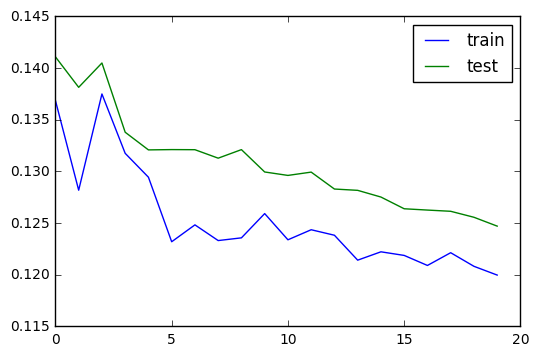

In [19]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [20]:
# make a prediction
yhat = model.predict(test_X)


In [21]:
# invert scaling for forecas
# combine original scaled data and predicted answer, set the predicted answer to the 
# original position
original_test = original_data.iloc[n_train_min:]
before = [("var%d(t)"%i)for i in range(1,8)]
after = [("var%d(t)"%i)for i in range(9,11)]
inv_yhat = concatenate((original_test[before],yhat,original_test[after]),axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,7]

In [22]:
# invert scaling for actual
original_test = original_data.iloc[n_train_min:]
original_recover = scaler.inverse_transform(original_test)
inv_y = original_recover[:,7]


In [23]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.840
